In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
STEPS = [('speech activity detection', 'limsi/baseline.0.seg'),
         ('resegmentation', 'limsi/baseline.1.seg'),
         ('BIC clustering', 'limsi/baseline.2.seg'),
         ('Viterbi resegmentation', 'limsi/baseline.3.seg'),
         ('Gender/band', 'limsi/baseline.stage1.seg'),
         ('CLR clustering', 'limsi/baseline.stage2.seg')]

In [44]:
STEPS = [('segmentation', 'limsi/baseline.1.seg'),
         ('BIC clustering', 'limsi/baseline.2.seg'),
         ('Viterbi resegmentation', 'limsi/baseline.3.seg'),
         ('CLR clustering', 'limsi/baseline.stage2.seg')]

In [45]:
from pyannote.parser import SEGParser
steps = {name: SEGParser().read(path, modality='speaker') 
         for name, path in STEPS}

In [46]:
from pyannote.database import get_protocol
from pyannote.database.util import get_annotated
protocol = get_protocol('Etape.SpeakerDiarization.TV', progress=True)

In [47]:
from pyannote.metrics.diarization import DiarizationPurity
from pyannote.metrics.diarization import DiarizationCoverage
from pyannote.metrics.diarization import GreedyDiarizationErrorRate

In [48]:
purity = {name: DiarizationPurity(parallel=False) for name, _ in STEPS}
coverage = {name: DiarizationCoverage(parallel=False) for name, _ in STEPS}
error = {name: GreedyDiarizationErrorRate(parallel=False) for name, _ in STEPS}

In [49]:
for item in protocol.development():
    reference = item['annotation']
    uem = get_annotated(item)
    for i, (name, _) in enumerate(STEPS):
        hypothesis = steps[name](item['uri'])
        purity[name](reference, hypothesis, uem=uem)
        coverage[name](reference, hypothesis, uem=uem)
        error[name](reference, hypothesis, uem=uem)

Development set: 9it [00:46,  4.96s/it]


In [53]:
e = np.array([abs(error[name]) for name, _ in STEPS])
p = np.array([abs(purity[name]) for name, _ in STEPS])
c = np.array([abs(coverage[name]) for name, _ in STEPS])

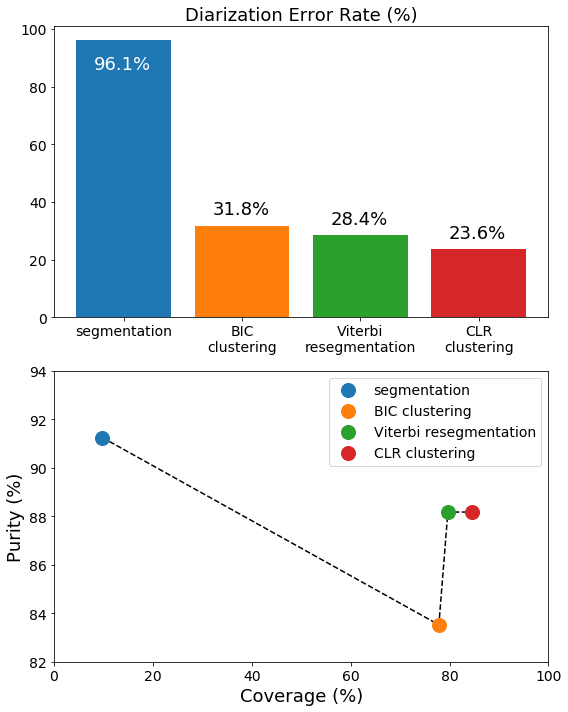

In [134]:
figsize(8, 10)
subplot(211)
indices = np.array((range(len(STEPS))))
bar(indices, 100 * e, 
    color=['C{0}'.format(i) for i in indices])

for i in indices:
    if e[i] > 0.9:
        gca().text(i-0.25, 100 * e[i] - 10, '{0:.1f}%'.format(100*e[i]), 
                   fontsize=18, color='white')
    else:
        gca().text(i-0.25, 100 * e[i] + 4, '{0:.1f}%'.format(100*e[i]), 
                   fontsize=18, color='black')
gca().set_xticks(indices)
gca().set_xticklabels(['\n'.join(name.split()) for name, _ in STEPS], fontsize=14)
gca().set_yticks([0, 20, 40, 60, 80, 100])
gca().set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
title('Diarization Error Rate (%)', fontsize=18)
subplot(212)
plot(100 * c, 100 * p, 'k--') 
xlabel('Coverage (%)', fontsize=18)
ylabel('Purity (%)', fontsize=18)
for i, (name, _) in enumerate(STEPS):
    plot([100 * c[i]], [100 * p[i]], 'C{0}o'.format(i), markersize=14, label=name)
legend(fontsize=14)
xlim(0, 100)
ylim(82, 94)
gca().set_yticks([82, 84, 86, 88, 90, 92, 94])
gca().set_yticklabels([82, 84, 86, 88, 90, 92, 94], fontsize=14)
gca().set_xticks([0, 20, 40, 60, 80, 100])
gca().set_xticklabels([0, 20, 40, 60, 80, 100], fontsize=14)
tight_layout()
savefig('../figures/diagnostic.pdf')